# CLAY v0 - Interpolation between images

In [1]:
import sys

sys.path.append("../")

In [2]:
import os
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from PIL import Image

from src.datamodule import ClayDataModule, ClayDataset
from src.model_clay import CLAYModule

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = "../data/02"  # data directory for all chips
CKPT_PATH = "../checkpoints/v0/mae_epoch-24_val-loss-0.46.ckpt"  # path of best model checkpoint for Clay v0

## Load Model & DataModule

In [4]:
# Load the model & set in eval mode
model = CLAYModule.load_from_checkpoint(
    CKPT_PATH, mask_ratio=0.0, shuffle=False
)  # No masking or shuffling of patches
model.eval();

In [5]:
data_dir = Path(DATA_DIR)

# Load the Clay DataModule
ds = ClayDataset(chips_path=list(data_dir.glob("**/*.tif")))
dm = ClayDataModule(data_dir=str(data_dir), batch_size=2)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [6]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [7]:
batch["pixels"].shape, batch["latlon"].shape, batch["timestep"].shape

(torch.Size([2, 13, 512, 512]), torch.Size([2, 2]), torch.Size([2, 3]))

In [8]:
def show(sample, idx=None, save=False):
    Path("animate").mkdir(exist_ok=True)
    sample = rearrange(sample, "c h w -> h w c")
    denorm_sample = sample * torch.as_tensor(dm.STD) + torch.as_tensor(dm.MEAN)
    rgb = denorm_sample[..., [2, 1, 0]]
    plt.imshow((rgb - rgb.min()) / (rgb.max() - rgb.min()))
    plt.axis("off")
    if save:
        plt.savefig(f"animate/chip_{idx}.png")

In [9]:
sample1, sample2 = batch["pixels"]

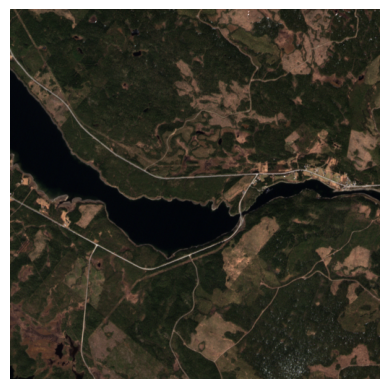

In [10]:
show(sample1)

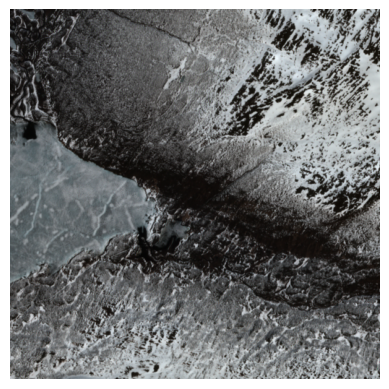

In [11]:
show(sample2)

Each batch has chips of shape `13 x 512 x 512`, normalized `lat` & `lon` coords & normalized timestep information as `year`, `month` & `day`.

In [12]:
# Save a copy of batch to visualize later
_batch = batch["pixels"].detach().clone().cpu().numpy()

## Pass data through the CLAY model

In [13]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(model.device)
    batch["timestep"] = batch["timestep"].to(model.device)
    batch["latlon"] = batch["latlon"].to(model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    (
        unmasked_patches,
        unmasked_indices,
        masked_indices,
        masked_matrix,
    ) = model.model.encoder(batch)

#### Create an image based on interpolation of the embedding values between 2 images
*Images are saved inside `./animate`*

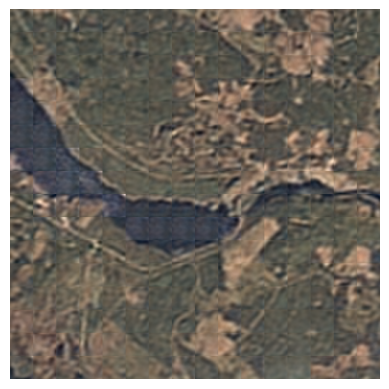

In [14]:
for idx, alpha in enumerate(np.linspace(0, 1, 20)):
    patch_break = 128
    l1, l2 = unmasked_patches
    l3 = alpha * l1 + (1 - alpha) * l2
    l4 = torch.vstack((l1[:patch_break, :], l2[patch_break:, :]))

    # Pass the unmasked_patches through the decoder to reconstruct the pixel space
    with torch.no_grad():
        pixels = model.model.decoder(
            rearrange(l3, "gl d -> 1 gl d"), unmasked_indices[[0]], masked_indices[[0]]
        )

    image = rearrange(pixels, "b c (h w) (p1 p2) -> b c (h p1) (w p2)", h=16, p1=32)
    _image = image[0].detach().cpu()
    show(_image, idx, save=True)

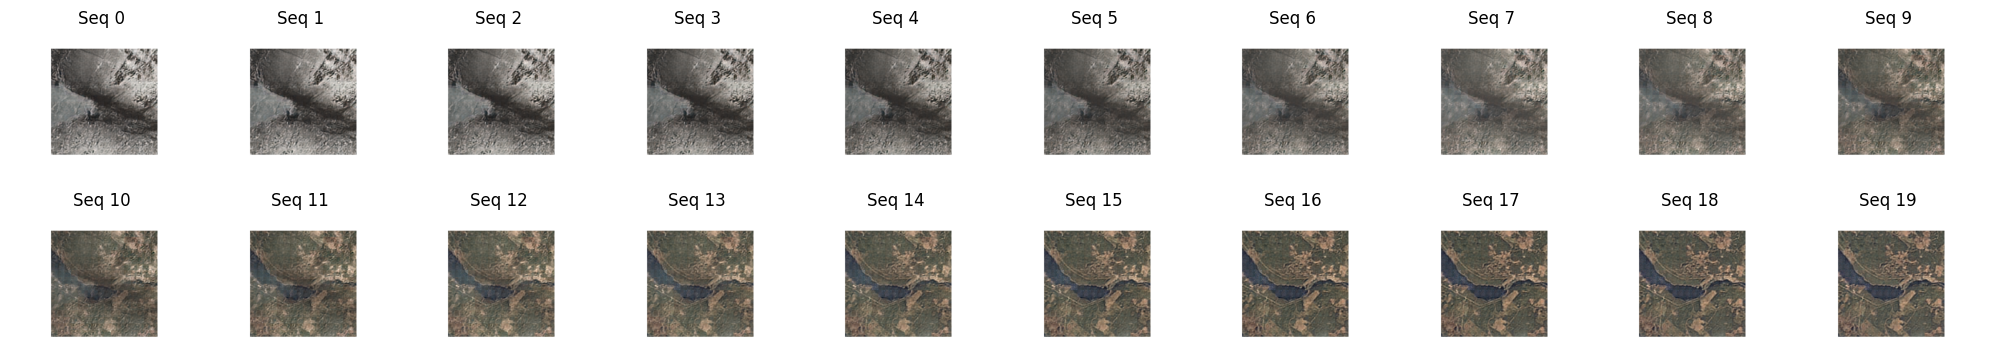

In [15]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for ax, idx in zip(axs.flatten(), range(20)):
    ax.imshow(Image.open(f"./animate/chip_{idx}.png"))
    ax.set_title(f"Seq {idx}")
    ax.set_axis_off()
plt.tight_layout()

#### Create a GIF of the interpolation of images

In [16]:
img_paths = [f"./animate/chip_{idx}.png" for idx in range(20)]

with imageio.get_writer("animate/sample.gif", mode="I", duration=100) as writer:
    for img_path in img_paths:
        img = imageio.imread(img_path)
        writer.append_data(img)

# Delete the images
for img_path in img_paths:
    os.remove(img_path)

/tmp/ipykernel_29043/2551327301.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


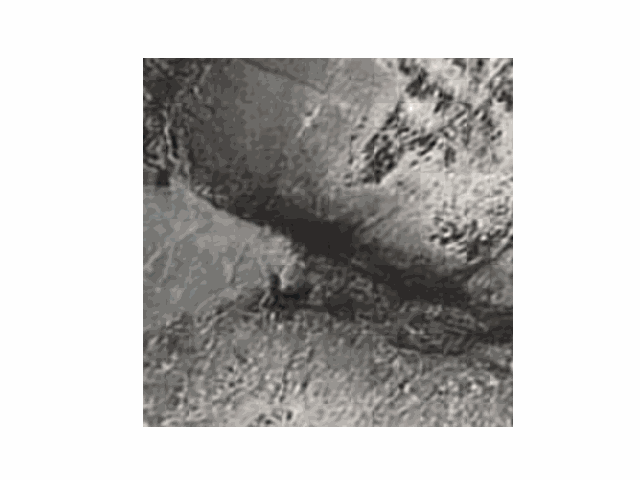

In [17]:
from IPython.display import Image, display

display(Image(filename="./animate/sample.gif"))